<a href="https://colab.research.google.com/github/hikiofni/BACKTESTT/blob/master/EGLD_USDT_Trix_Complete_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install python-binance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 11.1 MB/s 
     |████████████████████████████████| 288 kB 63.8 MB/s 
     |████████████████████████████████| 214 kB 55.0 MB/s 
     |████████████████████████████████| 103 kB 53.0 MB/s 
     |████████████████████████████████| 271 kB 40.6 MB/s 
     |████████████████████████████████| 192 kB 54.6 MB/s 
     |████████████████████████████████| 160 kB 50.7 MB/s 


In [4]:
pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=8f7d282c7f26d55e1383cecfab499788c41714237a5a54b83d2a73c5ea403cb3
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


<h1>Load yours data</h1>

In [5]:
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "EGLDUSDT"
startDate = "25 may 2016"
timeInterval = Client.KLINE_INTERVAL_1HOUR

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Data loaded 100%


<h1>Define your indicators</h1>

In [6]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Indicators, you can edit every value --
df['EMA200'] = ta.trend.ema_indicator(close=df['close'], window=200)
# -- Trix Indicator --
trixLength = 8
trixSignal = 17
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'],trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']

# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=15, smooth1=3, smooth2=3)
top = 0.82
bottom = 0.21
print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

Indicators loaded 100%


,open,high,low,close,volume,EMA200,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,,
2020-09-03 03:00:00,19.710,35.000,19.710,23.640,230806.88500000,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03 04:00:00,23.601,24.261,22.150,22.920,73034.90200000,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03 05:00:00,22.918,25.102,22.810,24.217,85861.99100000,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03 06:00:00,24.178,24.300,22.919,23.484,37018.33500000,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-03 07:00:00,23.482,23.800,20.975,22.801,58391.89900000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 07:00:00,320.370,323.000,319.030,321.970,7558.37000000,305.553006,316.847907,0.054744,0.051403,0.003341,1.000000
2021-11-10 08:00:00,322.020,332.610,321.190,329.670,26763.34400000,305.792976,317.165433,0.100214,0.047859,0.052355,1.000000
2021-11-10 09:00:00,329.640,335.380,326.300,335.130,16381.43650000,306.084887,317.707861,0.171023,0.049902,0.121122,1.000000


<h1>RUN the Spot Backtest</h1>

In [17]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2019-04-01':]

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

# -- You can change variables below --
usdt = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Do not touch these values --
initalWallet = usdt
wallet = usdt
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

# -- Condition to BUY market --
def buyCondition(row, previousRow):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < top:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, previousRow):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > bottom:
    return True
  else:
    return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
  # -- Buy market order --
  if buyCondition(row, previousRow) and usdt > 0 and buyReady == True:
    # -- You can define here at what price you buy --
    buyPrice = row['close']

    # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
    # stopLoss = buyPrice - 0.02 * buyPrice
    # takeProfit = buyPrice + 0.04 * buyPrice

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --
    # print("Buy COIN at",buyPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index, 'position': "Buy", 'reason':'Buy Market Order','price': buyPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  # -- Stop Loss --
  elif row['low'] < stopLoss and coin > 0:
    sellPrice = stopLoss
    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet
      
    # -- You can uncomment the line below if you want to see logs --
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Stop Loss','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)    

  # -- Sell Market Order --
  elif sellCondition(row, previousRow) and coin > 0 and sellReady == True:

    # -- You can define here at what price you buy --
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --  
    # print("Sell COIN at",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Market Order','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose) * 100
algoPercentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPercentage = ((algoPercentage - holdPercentage)/holdPercentage) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    totalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    totalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    totalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    totalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = totalBadTrades + totalGoodTrades
winRateRatio = (totalGoodTrades/totalTrades) * 100

reasons = dt['reason'].unique()

dt

,date,position,reason,price,frais,fiat,coins,wallet,drawBack,resultat,resultat%,tradeIs
date,,,,,,,,,,,,
2020-09-04 17:00:00,2020-09-04 17:00:00,Buy,Buy Market Order,17.701,0.039546,0,56.454438,999.300000,0.000000,NaN,NaN,
2020-09-05 11:00:00,2020-09-05 11:00:00,Sell,Sell Market Order,15.561,0.614941,877.873,0.000000,877.872562,-0.121512,-121.427438,-12.151250,Bad
2020-09-06 04:00:00,2020-09-06 04:00:00,Buy,Buy Market Order,11.906,0.051614,0,73.682013,877.258051,-0.122127,NaN,NaN,
2020-09-07 07:00:00,2020-09-07 07:00:00,Sell,Sell Market Order,12.270,0.632855,903.445,0.000000,903.445450,-0.095922,26.187398,2.985142,Good
2020-09-08 08:00:00,2020-09-08 08:00:00,Buy,Buy Market Order,14.206,0.044517,0,63.551530,902.813038,-0.096555,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-06 13:00:00,2021-11-06 13:00:00,Sell,Sell Market Order,307.180,44.414115,63404.3,0.000000,63404.321597,-0.055870,-1690.635951,-2.597184,Bad
2021-11-06 22:00:00,2021-11-06 22:00:00,Buy,Buy Market Order,315.440,0.140702,0,200.862093,63359.938572,-0.056531,NaN,NaN,
2021-11-07 12:00:00,2021-11-07 12:00:00,Sell,Sell Market Order,323.230,45.447258,64879.2,0.000000,64879.207017,-0.033908,1519.268445,2.397838,Good


<h1>Print Complete BackTest Analyses</h1>

In [16]:
print("Pair Symbol :",pairName)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage, 2), "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the", idbest)
print("Worst trade :", worstTrade, "%, the", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", totalGoodTrades)
print("Number of negative trades : ", totalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

Pair Symbol : EGLDUSDT
Period : [2021-04-01 00:00:00] -> [2021-11-10 11:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 5466.56 $
Performance vs US Dollar : 446.66 %
Buy and Hold Performence : 139.59 %
Performance vs Buy and Hold : 219.98 %
Best trade : +37.64 %, the 2021-06-29 19:00:00
Worst trade : -16.27 %, the 2021-06-22 14:00:00
Worst drawBack : -36.0 %
Total fees :  268.96 $

----- Trades Informations -----
Total trades on period : 165
Number of positive trades : 84
Number of negative trades :  81
Trades win rate ratio : 50.91 %
Average trades performance : 1.29 %
Average positive trades : 5.06 %
Average negative trades : -2.62 %

----- Trades Reasons -----
Buy Market Order number : 165
Sell Market Order number : 165


<h1>Plot to improve ...</h1>


----- Plot -----


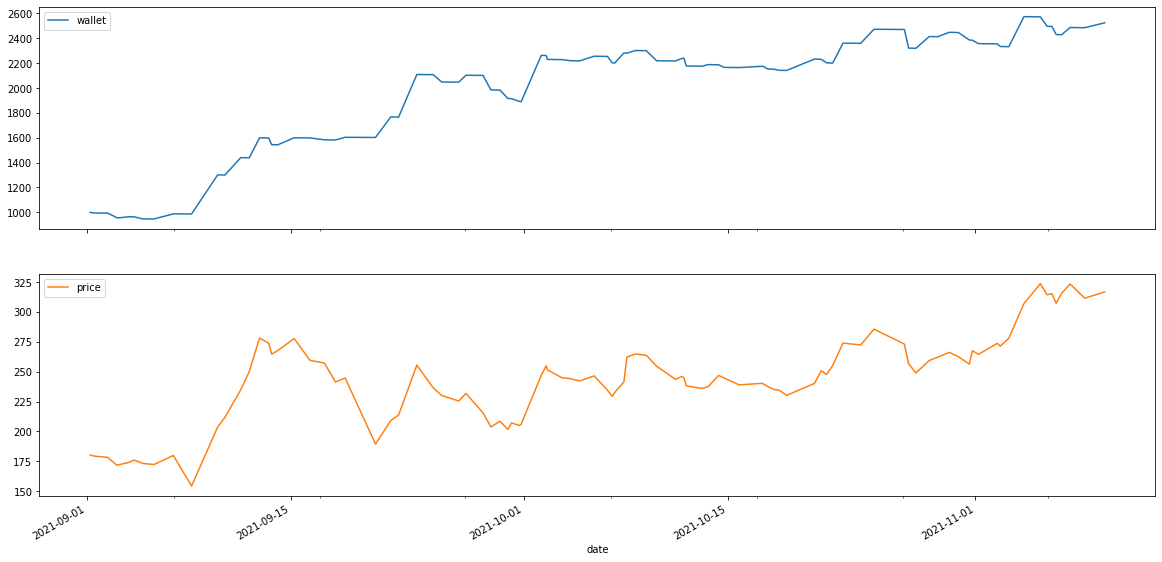

In [9]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")


----- Plot -----


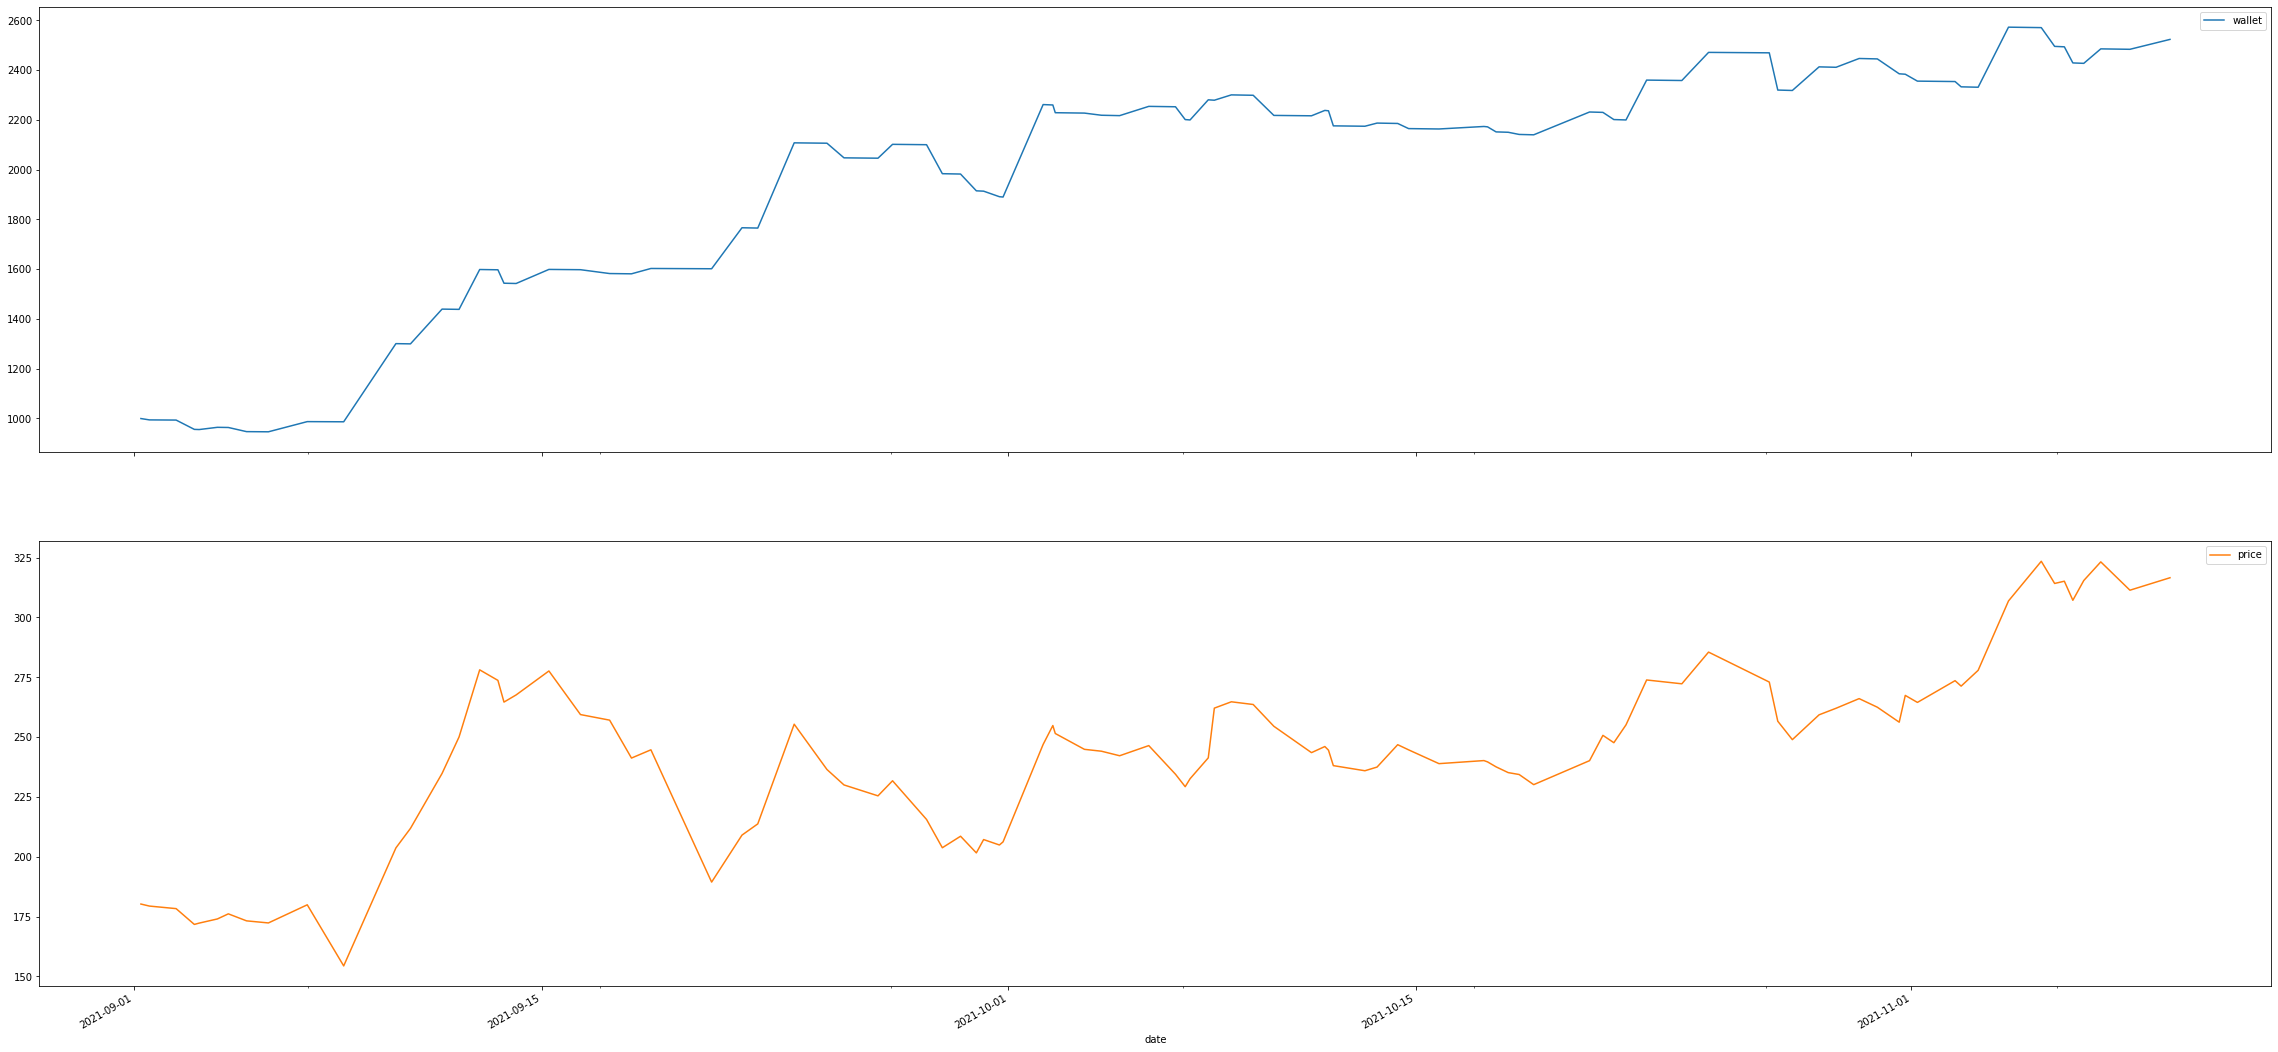

In [10]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(40, 20))
print("\n----- Plot -----")